In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='gold')
lview = c.load_balanced_view()

In [2]:
%%px
%env OMP_NUM_THREADS=1
%env KERAS_BACKEND=tensorflow
import matplotlib; matplotlib.use("agg")
import numpy as np
import sys

sys.path.insert(1, "/home/simonpf/src/typhon/")

from typhon.retrieval.qrnn   import QRNN
from typhon.retrieval.bmci   import BMCI
from typhon.retrieval.scores import mape, mean_quantile_score

[stdout:0] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:1] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:2] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:3] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:4] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:5] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:6] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:7] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:8] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:9] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:10] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:11] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:12] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:13] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:14] 
env: OMP_NUM_THREADS=1
env: KERAS_BACKEND=tensorflow
[stdout:15] 
env: OM

[stderr:0] Using TensorFlow backend.
[stderr:1] Using TensorFlow backend.
[stderr:2] Using TensorFlow backend.
[stderr:3] Using TensorFlow backend.
[stderr:4] Using TensorFlow backend.
[stderr:5] Using TensorFlow backend.
[stderr:6] Using TensorFlow backend.
[stderr:7] Using TensorFlow backend.
[stderr:8] Using TensorFlow backend.
[stderr:9] Using TensorFlow backend.
[stderr:10] Using TensorFlow backend.
[stderr:11] Using TensorFlow backend.
[stderr:12] Using TensorFlow backend.
[stderr:13] Using TensorFlow backend.
[stderr:14] Using TensorFlow backend.
[stderr:15] Using TensorFlow backend.


In [14]:
def evaluate_retrieval(n_train):
    ensemble_size = 1 
    x_train = np.load("/home/simonpf/src/atms_simulations/data/x_train_5.npy")
    x_test  = np.load("/home/simonpf/src/atms_simulations/data/x_test_5.npy")[:100000, :]
    y_train = np.load("/home/simonpf/src/atms_simulations/data/y_train_5.npy")
    y_test = np.load("/home/simonpf/src/atms_simulations/data/y_test_5.npy")[:100000]
    quantiles = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
    
    n_trials = 5
    
    mapes_qrnn           = np.zeros(n_trials)
    crpss_qrnn           = np.zeros(n_trials)
    quantile_losses_qrnn = np.zeros((n_trials, len(quantiles)))
    
    mapes_bmci           = np.zeros(n_trials)
    crpss_bmci           = np.zeros(n_trials)
    quantile_losses_bmci = np.zeros((n_trials, len(quantiles)))
    
    for i in range(n_trials):
        
        inds = np.random.permutation(x_train.shape[0])[:n_train]
        x_train_sub = x_train[inds, :]
        y_train_sub = y_train[inds]
        
        # qrnn training
        qrnn = QRNN(5, quantiles, 3, 256, ensemble_size = ensemble_size)
        qrnn.fit(x_train_sub, y_train_sub, sigma_noise = 1.0,
                 initial_learning_rate = 0.01,
                 learning_rate_decay = 2,
                 convergence_epochs = 10,
                 batch_size = 256,
                 maximum_epochs = 400,
                 learning_rate_minimum = 1e-4)
        
        # qrnn evaluation
        y_pred_qrnn = qrnn.predict(x_test)
        
        mapes_qrnn[i]              = mape(y_pred_qrnn[:, 5], y_test)
        crpss_qrnn[i]              = np.mean(QRNN.crps(y_pred_qrnn, y_test, quantiles))
        quantile_losses_qrnn[i, :] = mean_quantile_score(y_pred_qrnn, y_test, quantiles)
        
        # bmci
        bmci = BMCI(x_train_sub, y_train_sub, np.diag(np.ones(5)))
        y_pred_bmci = bmci.predict_quantiles(x_test, quantiles)
        
        mapes_bmci[i]              = mape(y_pred_bmci[:, 5], y_test)
        quantile_losses_bmci[i, :] = mean_quantile_score(y_pred_bmci, y_test, quantiles)
        crpss_bmci[i] = np.nanmean(bmci.crps(x_test, y_test))
        
    return (mapes_qrnn,
            crpss_qrnn,
            quantile_losses_qrnn,
            mapes_bmci,
            crpss_bmci,
            quantile_losses_bmci)


In [15]:
import numpy as np
n_train =  np.logspace(3, 6, 20)
rs = lview.map_async(evaluate_retrieval, np.array(n_train, dtype = int))


In [59]:
n_train =  np.logspace(3, 6, 20)

In [60]:
mapes_qrnn = np.zeros((20, 5))
crps_qrnn = np.zeros((20, 5))
quantile_losses_qrnn = np.zeros((20, 5, 11))
mapes_bmci = np.zeros((20, 5))
crps_bmci = np.zeros((20, 5))
quantile_losses_bmci = np.zeros((20, 5, 11))

for i,r in enumerate(rs):
    mapes_qrnn[i, :] = r[0]
    crps_qrnn[i, :]  = r[1]
    quantile_losses_qrnn[i, :, :] = r[2]

    mapes_bmci[i, :] = r[3]
    crps_bmci[i, :]  = r[4]
    quantile_losses_bmci[i, :, :] = r[5]

np.save("data/n_train", n_train)    
np.save("data/mapes_qrnn", mapes_qrnn)
np.save("data/crps_qrnn", crps_qrnn)
np.save("data/quantile_losses_qrnn", quantile_losses_qrnn)
np.save("data/mapes_bmci", mapes_bmci)
np.save("data/crps_bmci", crps_bmci)
np.save("data/quantile_losses_bmci", quantile_losses_bmci)

## Plots

In [61]:
import numpy as np
import matplotlib_settings
import matplotlib.pyplot as plt

n_train = np.load("data/n_train.npy")
mapes_qrnn = np.load("data/mapes_qrnn.npy")
crpss_qrnn = np.load("data/crps_qrnn.npy")
ql_qrnn    = np.load("data/quantile_losses_qrnn.npy")
mapes_bmci = np.load("data/mapes_bmci.npy")
crpss_bmci = np.load("data/crps_bmci.npy")
ql_bmci    = np.load("data/quantile_losses_bmci.npy")

### MAPE & CRPS

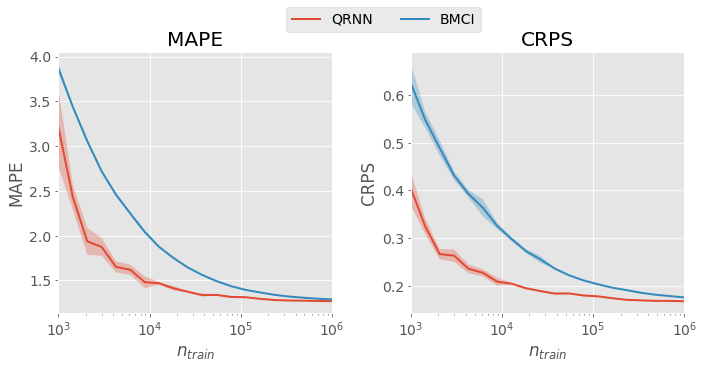

In [62]:
means_qrnn = mapes_qrnn.mean(axis = 1)
std_qrnn   = mapes_qrnn.std(axis = 1)
means_bmci = mapes_bmci.mean(axis = 1)
std_bmci   = mapes_bmci.std(axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (10,5))

ax[0].plot(n_train, means_qrnn, label = "QRNN", lw = 2)
ax[0].fill_between(n_train, means_qrnn - std_qrnn, means_qrnn + std_qrnn, label = "QRNN", lw = 2, alpha = 0.3)
ax[0].plot(n_train, means_bmci, label = "BMCI", lw = 2)
ax[0].fill_between(n_train, means_bmci - std_bmci, means_bmci + std_bmci, label = "BMCI", lw = 2, alpha = 0.3)
ax[0].set_title("MAPE")
ax[0].set_xscale("log")
ax[0].set_xlim([10**3, 10**6])
ax[0].set_xlabel("$n_{train}$")
ax[0].set_ylabel("MAPE")

means_qrnn = crps_qrnn.mean(axis = 1)
std_qrnn   = crps_qrnn.std(axis = 1)
means_bmci = crps_bmci.mean(axis = 1)
std_bmci   = crps_bmci.std(axis = 1)

ax[1].plot(n_train, means_qrnn, label = "QRNN", lw = 2)
ax[1].fill_between(n_train, means_qrnn - std_qrnn, means_qrnn + std_qrnn, lw = 2, alpha = 0.3)
ax[1].plot(n_train, means_bmci, label = "BMCI", lw = 2)
ax[1].fill_between(n_train, means_bmci - std_bmci, means_bmci + std_bmci, lw = 2, alpha = 0.3)
ax[1].set_title("CRPS")
ax[1].set_xscale("log")
ax[1].set_xlim([10**3, 10**6])
ax[1].set_xlabel("$n_{train}$")
ax[1].set_ylabel("CRPS")
ax[1].legend(loc = "upper center", bbox_to_anchor = [-0.1, 1.20], ncol = 2)
plt.tight_layout()

fig.savefig("plots/mape_crps.pdf", bbox_inches = "tight")

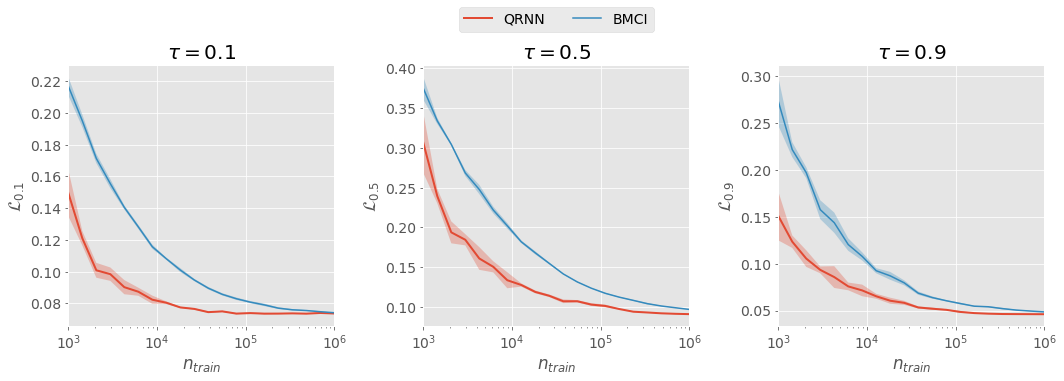

In [63]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
mean_ql_qrnn = np.mean(ql_qrnn, axis = 1)
std_ql_qrnn  = np.std(ql_qrnn, axis = 1)
mean_ql_bmci = np.mean(ql_bmci, axis = 1)
std_ql_bmci  = np.std(ql_bmci, axis = 1)

# 10th percentile
axs[0].plot(n_train, mean_ql_qrnn[:, 1], label = "QRNN", lw = 2)
axs[0].fill_between(n_train,
                     mean_ql_qrnn[:, 1] - std_ql_qrnn[:, 1],
                     mean_ql_qrnn[:, 1] + std_ql_qrnn[:, 1],
                     alpha = 0.3)
axs[0].plot(n_train, mean_ql_bmci[:, 1])
axs[0].fill_between(n_train,
                     mean_ql_bmci[:, 1] - std_ql_bmci[:, 1],
                     mean_ql_bmci[:, 1] + std_ql_bmci[:, 1],
                     alpha = 0.3)
axs[0].set_title(r"$\tau = 0.1$")
axs[0].set_xlim([10 ** 3, 10 ** 6])
axs[0].set_xlabel(r"$n_{train}$")
axs[0].set_xscale("log")
axs[0].set_ylabel(r"$\mathcal{L}_{0.1}$")

# median
axs[1].plot(n_train, mean_ql_qrnn[:, 5], label = "QRNN", lw = 2)
axs[1].fill_between(n_train,
                     mean_ql_qrnn[:, 5] - std_ql_qrnn[:, 5],
                     mean_ql_qrnn[:, 5] + std_ql_qrnn[:, 5],
                     alpha = 0.3)
axs[1].plot(n_train, mean_ql_bmci[:, 5], label = "BMCI")
axs[1].fill_between(n_train,
                     mean_ql_bmci[:, 5] - std_ql_bmci[:, 5],
                     mean_ql_bmci[:, 5] + std_ql_bmci[:, 5],
                     alpha = 0.3)
axs[1].set_title(r"$\tau = 0.5$")
axs[1].set_xlabel(r"$n_{train}$")
axs[1].set_xscale("log")
axs[1].set_xlim([10 ** 3, 10 ** 6])
axs[1].set_ylabel(r"$\mathcal{L}_{0.5}$")
axs[1].legend(loc = "upper center", bbox_to_anchor = [0.5, 1.25], ncol = 2)

# 90th percentile
axs[2].plot(n_train, mean_ql_qrnn[:, 10], label = "QRNN", lw = 2)
axs[2].fill_between(n_train,
                     mean_ql_qrnn[:, 10] - std_ql_qrnn[:, 10],
                     mean_ql_qrnn[:, 10] + std_ql_qrnn[:, 10],
                     alpha = 0.3)
axs[2].plot(n_train, mean_ql_bmci[:, 10], label = "BMCI")
axs[2].fill_between(n_train,
                     mean_ql_bmci[:, 10] - std_ql_bmci[:, 10],
                     mean_ql_bmci[:, 10] + std_ql_bmci[:, 10],
                     alpha = 0.3)
axs[2].set_title(r"$\tau = 0.9$")
axs[2].set_xlabel(r"$n_{train}$")
axs[2].set_xscale("log")
axs[2].set_xlim([10 ** 3, 10 ** 6])
axs[2].set_ylabel(r"$\mathcal{L}_{0.9}$")

plt.tight_layout()
fig.savefig("plots/quantile_losses.pdf", bbox_inches = "tight")